# Gamma Mass attenuation

## Functions

In [9]:
# %load ../../setup.py
"""
Packages for plotting and other stuff
version: 5.0
author: Riasat
"""
# %matplotlib widget

# data loading
import pandas as pd

# data maipulation
import pwlf
import numpy as np
from scipy.interpolate import interp1d, UnivariateSpline
from scipy.signal import find_peaks
from scipy import optimize

# plotting tools
import matplotlib.pyplot as plt

# extra tweaks
import warnings

warnings.filterwarnings("ignore")

# plot tweaks
plt.style.use("seaborn-poster")
pd.options.display.max_columns = None
pd.options.display.float_format = "{:.5f}".format

# function for extrapolation
def extrapolate1d(x, y):
    f = interp1d(x, y, kind="linear", fill_value="extrapolate")
    a = np.arange(0, x[len(x) - 1], 0.001)
    b = f(a)
    return a, b


# function for interpolation
def interpolate1d(x, y):
    f = interp1d(x, y, kind="linear", fill_value="extrapolate")
    a = np.arange(x[0], x[len(x) - 1], 0.001)
    b = f(a)
    return a, b


# function for interpolation
def interpolate2d(x, y):
    f = interp1d(x, y, kind="quadratic", fill_value="extrapolate")
    a = np.arange(x[0], x[len(x) - 1], 0.001)
    b = f(a)
    return a, b


# function for interpolation
def interpolate3d(x, y):
    f = interp1d(x, y, kind="cubic", fill_value="extrapolate")
    a = np.arange(x[0], x[len(x) - 1], 0.001)
    b = f(a)
    return a, b


# funciton for polynomial fitting
def polfit(a, b, c):
    z = np.polyfit(a, b, c)
    f = np.poly1d(z)

    x = np.arange(a[0], a[len(a) - 1], 0.001)
    y = f(x)
    return x, y


# function for picewise linear fit
def picewise_linear_fit(x, y, segments):
    my_pwlf = pwlf.PiecewiseLinFit(x, y)  # fit my data
    res = my_pwlf.fit(segments)  # fit the data for n line segments
    # slopes = myPWLF.calc_slopes()  # calculate slopes

    # predict for the determined points
    xHat = np.linspace(min(x), max(x), num=10000)
    yHat = my_pwlf.predict(xHat)

    # calculate statistics
    # p = myPWLF.p_values(method="non-linear", step_size=1e-4)  # p-values
    # se = myPWLF.se  # standard errors
    return xHat, yHat


# curve fit
def cur_fit(x, y):
    func = lambda t, a, c, d: a * np.log(t + c) + d
    popt, pcov = optimize.curve_fit(func, x, y)  # type: ignore
    xx = np.arange(x[0], x[len(x) - 1], 0.001)
    yy = func(xx, *popt)
    return xx, yy


## Data


In [10]:
file_name = "data_mass_attenuation.xlsx"
# background count variable in units of counts per minute calculated at the operating voltage of 460V
bg_count = 50

# plateau datas
data_plateau = pd.read_excel(file_name, sheet_name="plateau")
pl_voltage = data_plateau["p_voltage"]
pl_counts = data_plateau["p_counts"]

# thickness data
data_thickness_al = pd.read_excel(file_name, sheet_name="aluminium")
data_thickness_cu = pd.read_excel(file_name, sheet_name="copper")
data_thickness_ag = pd.read_excel(file_name, sheet_name="silver")

# alluminium datas
al_thickness_original = data_thickness_al["al_thickness"]
al_counts_original = data_thickness_al["al_counts"] - bg_count
data_thickness_al['net_counts'] = al_counts_original
# copper datas
cu_thickness_original = data_thickness_cu["cu_thickness"]
cu_counts_original = data_thickness_cu["cu_counts"] - bg_count
data_thickness_cu['net_counts'] = cu_counts_original
# silver datas
ag_thickness_original = data_thickness_ag["ag_thickness"]
ag_counts_original = data_thickness_ag["ag_counts"] - bg_count
data_thickness_ag['net_counts'] = ag_counts_original

print(f"{data_thickness_ag}")


    ag_thickness  ag_counts  net_counts
0        0.00000       2690        2640
1        0.06200       1769        1719
2        0.06500       1565        1515
3        0.07300       1589        1539
4        0.08600       1471        1421
5        0.09800       1419        1369
6        0.12700       1432        1382
7        0.13500       1357        1307
8        0.15900       1408        1358
9        0.17100       1317        1267
10       0.18400       1324        1274
11       0.20000       1360        1310
12       0.22000       1338        1288


## Operating Voltage


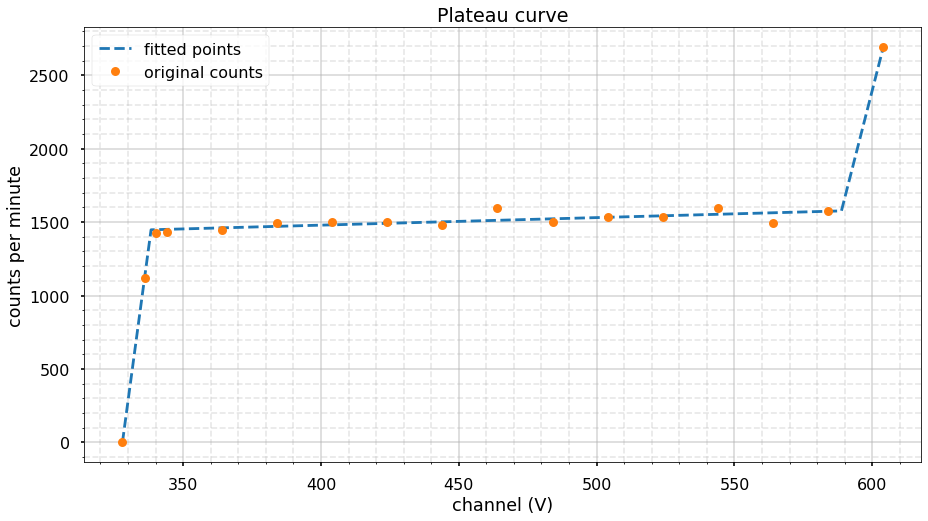

In [11]:
# fitted points
voltage_interpolated_pl, counts_interpolated_pl = picewise_linear_fit(pl_voltage, pl_counts,3)

plt.style.use("seaborn-poster")
plt.figure(figsize=(15, 8))
plt.title(f"Plateau curve")
plt.xlabel("channel (V)")
plt.ylabel("counts per minute")
plt.plot(voltage_interpolated_pl, counts_interpolated_pl, "--", label="fitted points")
plt.plot(pl_voltage, pl_counts, "o", markersize=9, label="original counts")
plt.legend(loc="upper left")
plt.grid(alpha=0.5, which="major")
plt.minorticks_on()
plt.grid(alpha=0.3, which="minor", ls="--")
plt.show()


I have chosen the operating voltage at 464 V


# Thickness Curve

Varying the absorber in the GM counter tube.


In [12]:
thickness_fitted_al, counts_fitted_al = polfit(al_thickness_original, al_counts_original, 3)
thickness_fitted_cu, counts_fitted_cu = polfit(cu_thickness_original, cu_counts_original, 4)
thickness_fitted_ag, counts_fitted_ag = polfit(ag_thickness_original, ag_counts_original, 4)

element_name = ["Al", "Cu", "Ag"]
thickness_fitted = [thickness_fitted_al, thickness_fitted_cu, thickness_fitted_ag]
counts_fitted = [counts_fitted_al, counts_fitted_cu, counts_fitted_ag]
thickness_original = [al_thickness_original, cu_thickness_original, ag_thickness_original]
counts_original = [al_counts_original, cu_counts_original, ag_counts_original]

# finding the half width
thickness_half = []
c_half = []
for i in range(len(element_name)):
    count_half = counts_fitted[i][0] / 2
    c_half.append(count_half)
    th = interp1d(counts_fitted[i], thickness_fitted[i], kind="cubic")
    thickness_half.append(th(count_half))
    print(
        f"{element_name[i]}: \n max count = {counts_fitted[i][0]:.0f}, half count = {count_half:.0f} \n\t half thickness = {thickness_half[i]:.2f} mm"
    )

Al: 
 max count = 2867, half count = 1434 
	 half thickness = 5.44 mm
Cu: 
 max count = 2669, half count = 1335 
	 half thickness = 0.25 mm
Ag: 
 max count = 2643, half count = 1322 
	 half thickness = 0.14 mm


## Calculation using the half thickness


In [13]:
linear_attenuation = []
mass_attenuation = []
density_metal = [2.7, 8.92, 10.5]
for i in range(len(element_name)):
	# linear mass attenuation
	la = (0.693*10)/thickness_half[i]
	linear_attenuation.append(la)
	# mass attenuation coefficient
	ma = la/density_metal[i]
	mass_attenuation.append(ma)
	print(f"{element_name[i]}:\n linear mass attenuation: {linear_attenuation[i]:.3f} cm^-1 \n mass attenuation coefficient: {mass_attenuation[i]:.3f} cm^2g^-1")

Al:
 linear mass attenuation: 1.273 cm^-1 
 mass attenuation coefficient: 0.472 cm^2g^-1
Cu:
 linear mass attenuation: 28.130 cm^-1 
 mass attenuation coefficient: 3.154 cm^2g^-1
Ag:
 linear mass attenuation: 51.226 cm^-1 
 mass attenuation coefficient: 4.879 cm^2g^-1


## Plots

### Aluminum


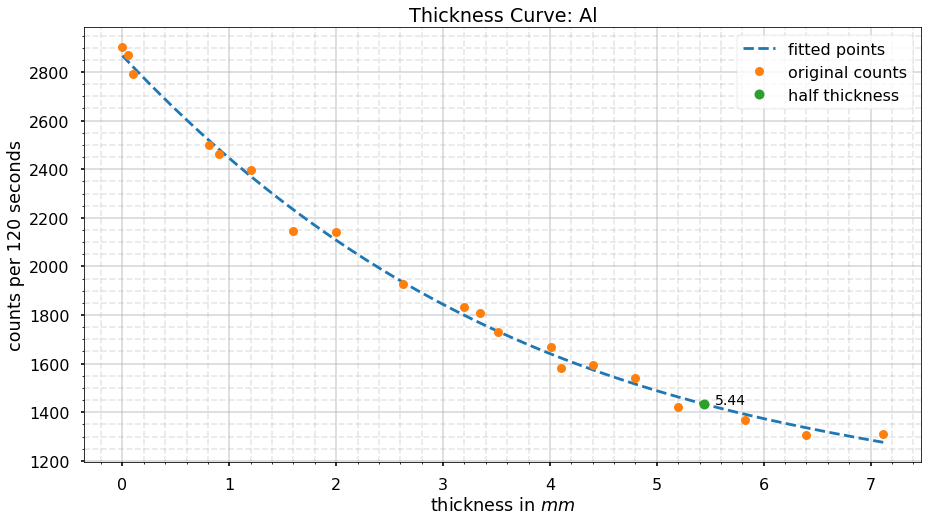

In [14]:
# plotting the curves
plt.style.use("seaborn-poster")
plt.figure(figsize=(15, 8))

plt.title(f"Thickness Curve: {element_name[0]}")
plt.xlabel(r"thickness in $mm$")
plt.ylabel("counts per 120 seconds")

plt.plot(thickness_fitted[0], counts_fitted[0], "--", label="fitted points")
plt.annotate(f"{thickness_half[0]:.2f}", xy=(thickness_half[0] + 0.1, c_half[0]), fontsize=14)
plt.plot(thickness_original[0], counts_original[0], "o", markersize=9, label="original counts")
plt.plot(thickness_half[0], c_half[0], "o", markersize=10, label="half thickness")

plt.legend(loc="upper right")
plt.grid(alpha=0.5, which="major")
plt.minorticks_on()
plt.grid(alpha=0.3, which="minor", ls="--")

plt.show()



### Copper


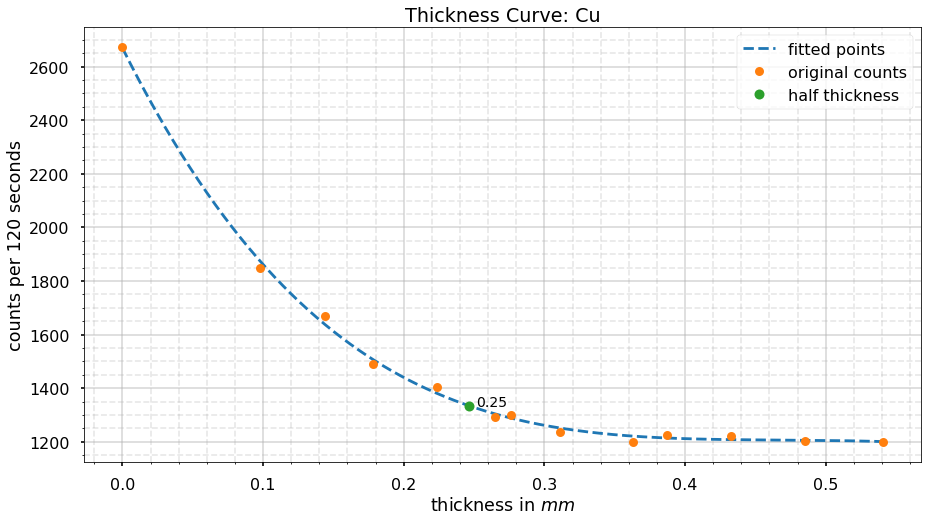

In [15]:
plt.style.use("seaborn-poster")
plt.figure(figsize=(15, 8))


plt.title(f"Thickness Curve: {element_name[1]}")
plt.xlabel(r"thickness in $mm$")
plt.ylabel("counts per 120 seconds")

plt.plot(thickness_fitted[1], counts_fitted[1], "--", label="fitted points")
plt.annotate(f"{thickness_half[1]:.2f}", xy=(thickness_half[1] + 0.005, c_half[1] ), fontsize=14)
plt.plot(thickness_original[1], counts_original[1], "o", markersize=9, label="original counts")
plt.plot(thickness_half[1], c_half[1], "o", markersize=10, label="half thickness")

plt.legend(loc="upper right")
plt.grid(alpha=0.5, which="major")
plt.minorticks_on()
plt.grid(alpha=0.3, which="minor", ls="--")

plt.show()


### Silver

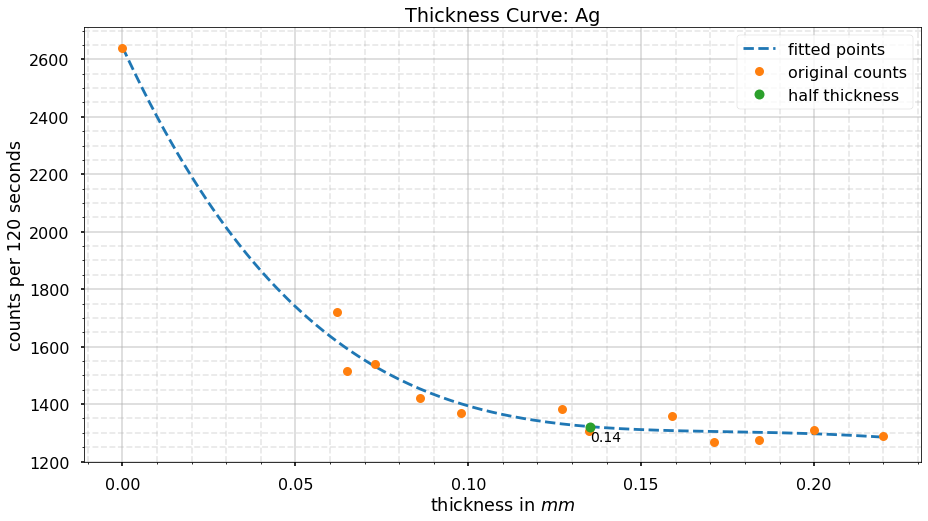

In [16]:
plt.style.use("seaborn-poster")
plt.figure(figsize=(15, 8))


plt.title(f"Thickness Curve: {element_name[2]}")
plt.xlabel(r"thickness in $mm$")
plt.ylabel("counts per 120 seconds")

plt.plot(thickness_fitted[2], counts_fitted[2], "--", label="fitted points")
plt.annotate(f"{thickness_half[2]:.2f}", xy=(thickness_half[2], c_half[2] - 50), fontsize=14)
plt.plot(thickness_original[2], counts_original[2], "o", markersize=9, label="original counts")
plt.plot(thickness_half[2], c_half[2], "o", markersize=10, label="half thickness")

plt.legend(loc="upper right")
plt.grid(alpha=0.5, which="major")
plt.minorticks_on()
plt.grid(alpha=0.3, which="minor", ls="--")

plt.show()
